In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *
import rasterio.mask as rio_mask
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *

# Comparison of plot characteristics and results

Here we first compare the annotations and predictions in field plot level metrics, and then do the same for predictions and field data. Comparison between annotations and predictions is done with all data within the virtual plot, whereas the comparisons between predictions and field data are done with the predictions intersecting the field plot circle.

# Hiidenportti

Read data and do some wrangling. Hiidenportti data comparisons are done only with five test virtual plots.

In [2]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
preds = gpd.read_file('../results/hiidenportti/merged_all_new.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_data.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
conservation_areas = gpd.read_file('../data/common/LsAlueValtio.shp')
cons_hp = conservation_areas[conservation_areas.geometry.intersects(box(*anns.total_bounds))]
cons_hp = gpd.clip(cons_hp, virtual_plot_grid)

Filter plot circles so that only those present in virtual plots remain.

In [3]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()

In [4]:
plot_circles = plot_circles[plot_circles.in_vplot == 1]

Convert `n_dw` (number of deadwood stems per hectare), `n_ddw` and `n_udw` to signify number of deadwood stems in circular plot with 9m radius.

In [5]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_ddw_plot'] = np.round((plot_dw_data['n_ddw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_udw_plot'] = plot_dw_data.n_dw_plot - plot_dw_data.n_ddw_plot

Some helper functions for data matching.

In [6]:
def match_circular_plot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)
        
def match_vplot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return f'{p.id}_{p.level_1}'

In [7]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Add relevant information to predictions.

In [8]:
preds['conservation'] = preds.geometry.apply(lambda row: 1 if any(cons_hp.geometry.contains(row))
                                                         else 0)

In [9]:
preds['plot_id'] = preds.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
preds_in_plots = preds[preds.geometry.intersects(plot_circles.geometry.unary_union)].copy()
preds_in_plots['plot_id'] = preds_in_plots.plot_id.astype(int)
preds['vplot_id'] = preds.apply(lambda row: match_vplot(row, virtual_plot_grid), axis=1)

Filter only test areas

In [10]:
anns_in_plots = anns_in_plots[anns_in_plots.plot_id.isin(preds_in_plots.plot_id.unique())]
plot_dw_data = plot_dw_data[plot_dw_data.id.isin(preds_in_plots.plot_id.unique())]
anns = anns[anns.vplot_id.isin(preds.vplot_id.unique())]

## Predictions vs annotations, with all data present in virtual plots

First crosstab the numbers of different deadwood types.

In [11]:
pd.crosstab(anns.conservation, anns.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,916,181,1097
1,485,159,644
All,1401,340,1741


In [12]:
pd.crosstab(preds.conservation, preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,1231,145,1376
1,811,155,966
All,2042,300,2342


Add tree length and diameter estimations.

In [13]:
anns['tree_length'] = anns.geometry.apply(get_len)
preds['tree_length'] = preds.geometry.apply(get_len)
anns['diam'] = anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
preds['diam'] = preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

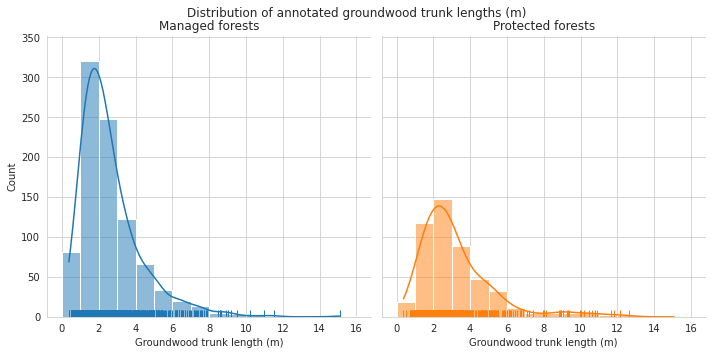

In [14]:
g = sns.displot(data=anns[anns.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

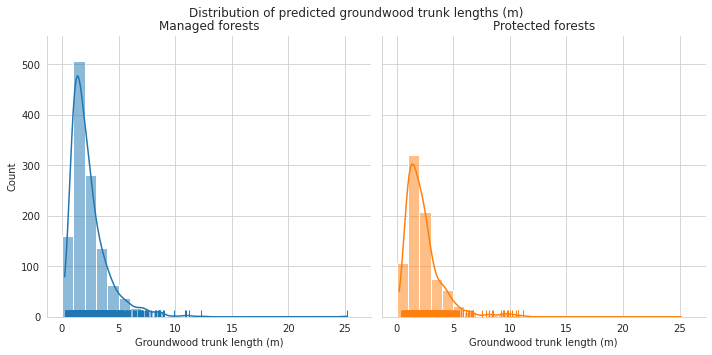

In [15]:
g = sns.displot(data=preds[preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

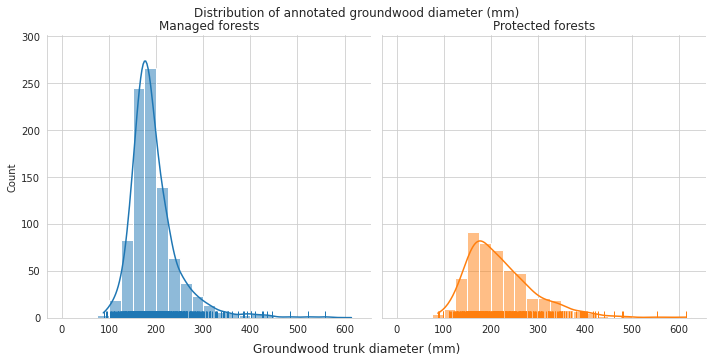

In [16]:
g = sns.displot(data=anns[(anns.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns[(anns.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

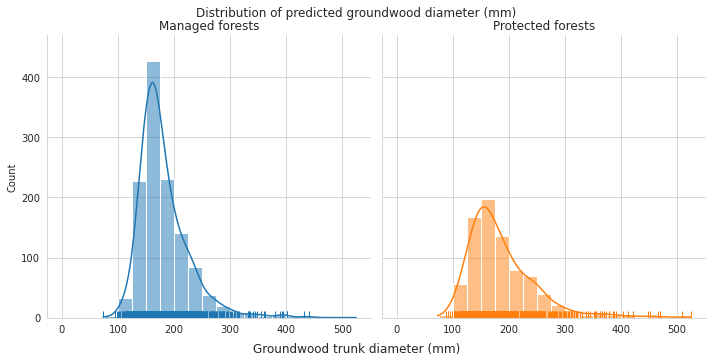

In [17]:
g = sns.displot(data=preds[(preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds[(preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [18]:
anns[anns.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             194.449747    2.621222  89.906915    0.383440  558.643918   
1             220.942312    3.208590  87.563515    0.371857  614.556062   
All           203.620977    2.824558  87.563515    0.371857  614.556062   

                          
             tree_length  
conservation              
0              15.087245  
1              12.617573  
All            15.087245

In [19]:
preds[preds.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             180.780434    2.348764  73.158266    0.234854  439.991265   
1             186.974617    2.336421  87.300045    0.415167  524.889097   
All           183.240514    2.343862  73.158266    0.234854  524.889097   

                          
             tree_length  
conservation              
0              25.146167  
1              11.149222  
All            25.146167

In [20]:
anns['area_m2'] = anns.geometry.area
preds['area_m2'] = preds.geometry.area

In [21]:
anns[anns.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                            aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.066763,555.084039
1,4.061288,645.744719
All,3.531849,1200.828758


In [22]:
preds[preds.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                              aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.266189,473.597352
1,3.630567,562.737808
All,3.454451,1036.335160


In [23]:
anns['v_ddw'] = anns.geometry.apply(cut_cone_volume)
preds['v_ddw'] = preds.geometry.apply(cut_cone_volume)

In [24]:
virtual_plot_grid['vplot_id'] = virtual_plot_grid.apply(lambda p: f'{p.id}_{p.level_1}', axis=1)

test_cons_areas = cons_hp.overlay(virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())])

test_vplot_area = virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())].area.sum()
test_cons_area = test_cons_areas.area.sum()
test_man_area = test_vplot_area - test_cons_area
test_man_ha = test_man_area / 10000
test_cons_ha = test_cons_area / 10000

In [25]:
ann_est_v_man = anns[(anns.layer=='groundwood')&(anns.conservation==0)].v_ddw.sum()/test_man_ha
ann_est_v_cons = anns[(anns.layer=='groundwood')&(anns.conservation==1)].v_ddw.sum()/test_cons_ha
ann_est_v_test = anns[(anns.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [26]:
pred_est_v_man = preds[(preds.layer=='groundwood')&(preds.conservation==0)].v_ddw.sum()/test_man_ha
pred_est_v_cons = preds[(preds.layer=='groundwood')&(preds.conservation==1)].v_ddw.sum()/test_cons_ha
pred_est_v_test = preds[(preds.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [27]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {ann_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 13.05 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 14.05 ha/m³
Estimated groundwood volume in both types, based on annotations: 13.50 ha/m³


In [28]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {pred_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 14.98 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 14.36 ha/m³
Estimated groundwood volume in both types, based on predictions: 14.70 ha/m³


## Predictions vs field data, with only predictions present in field plots

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [29]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==2].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==1].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==1].plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(cons_hp.geometry.contains(row.geometry))
                                                  else 0, axis=1)

In [30]:
plot_dw_data['n_dw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==2].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==1].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==1].plot_id.unique() else 0, axis=1)

In [31]:
plot_dw_data.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 
                                                       'n_ddw_ann', 'n_udw_ann',
                                                       'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,44,48,58,13,12,7
1,11,47,25,4,8,1
All,55,95,83,17,20,8


Get plot-wise canopy cover percentage based on LiDAR derived canopy height model as the percentage of plot area with height more than 2 meters.

In [32]:
pcts = []

with rio.open('../../data/raw/hiidenportti/full_mosaics/CHM_Hiidenportti_epsg.tif') as src:
    crs = src.crs
    for row in plot_dw_data.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [33]:
plot_dw_data['canopy_cover_pct'] = pcts

Plot the relationship between annotated deadwood and field data.

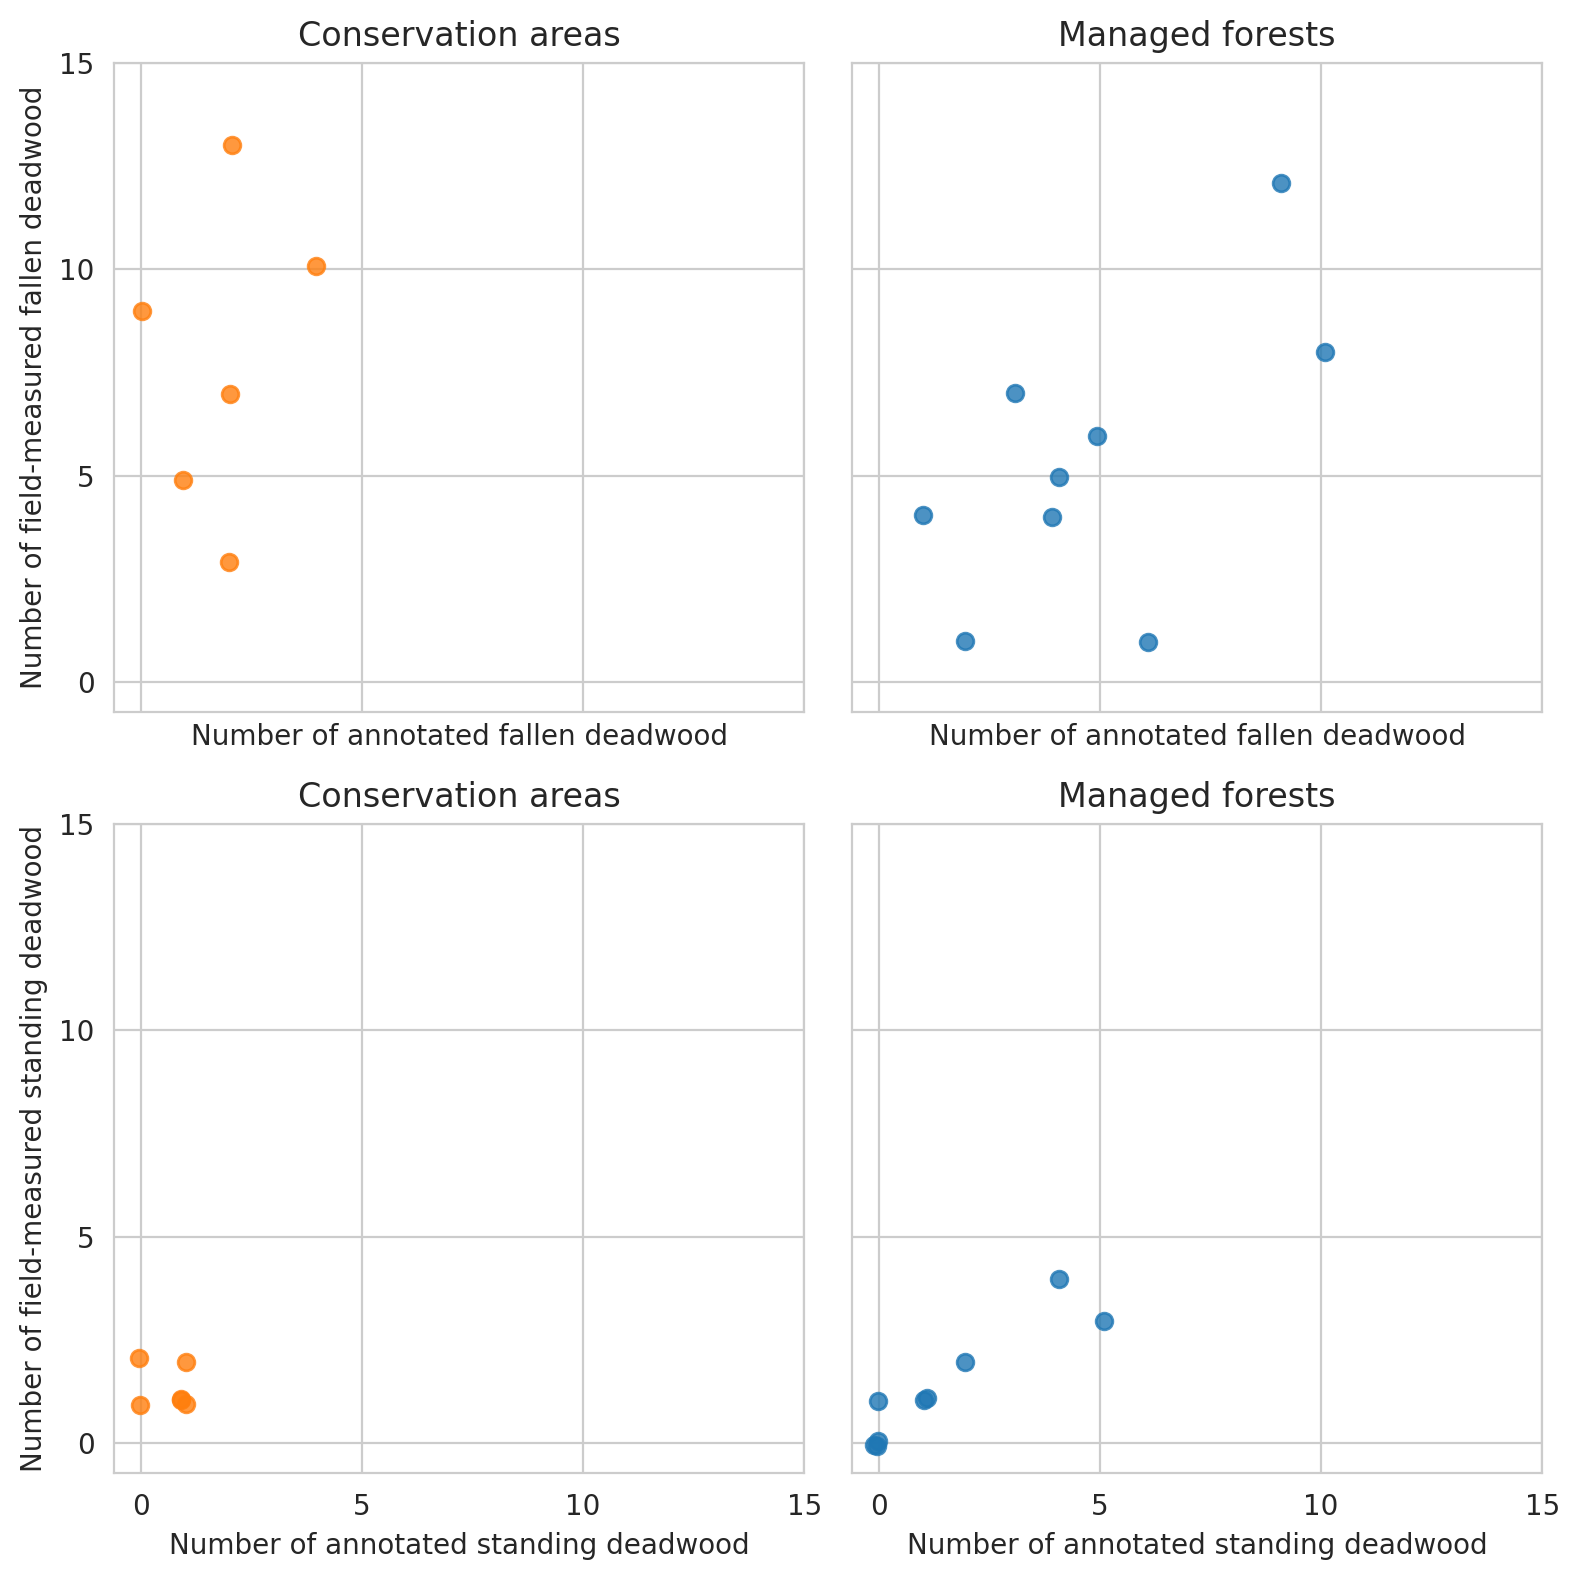

In [34]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,16,5))
ax[0,0].set_yticklabels(range(0,16,5))
ax[0,0].set_xticks(range(0,16,5))
ax[0,0].set_xticklabels(range(0,16,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,16,5))
ax[0,1].set_yticklabels(range(0,16,5))
ax[0,1].set_xticks(range(0,16,5))
ax[0,1].set_xticklabels(range(0,16,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,16,5))
ax[1,1].set_yticklabels(range(0,16,5))
ax[1,1].set_xticks(range(0,16,5))
ax[1,1].set_xticklabels(range(0,16,5))
plt.tight_layout()

Same for field data and predictions

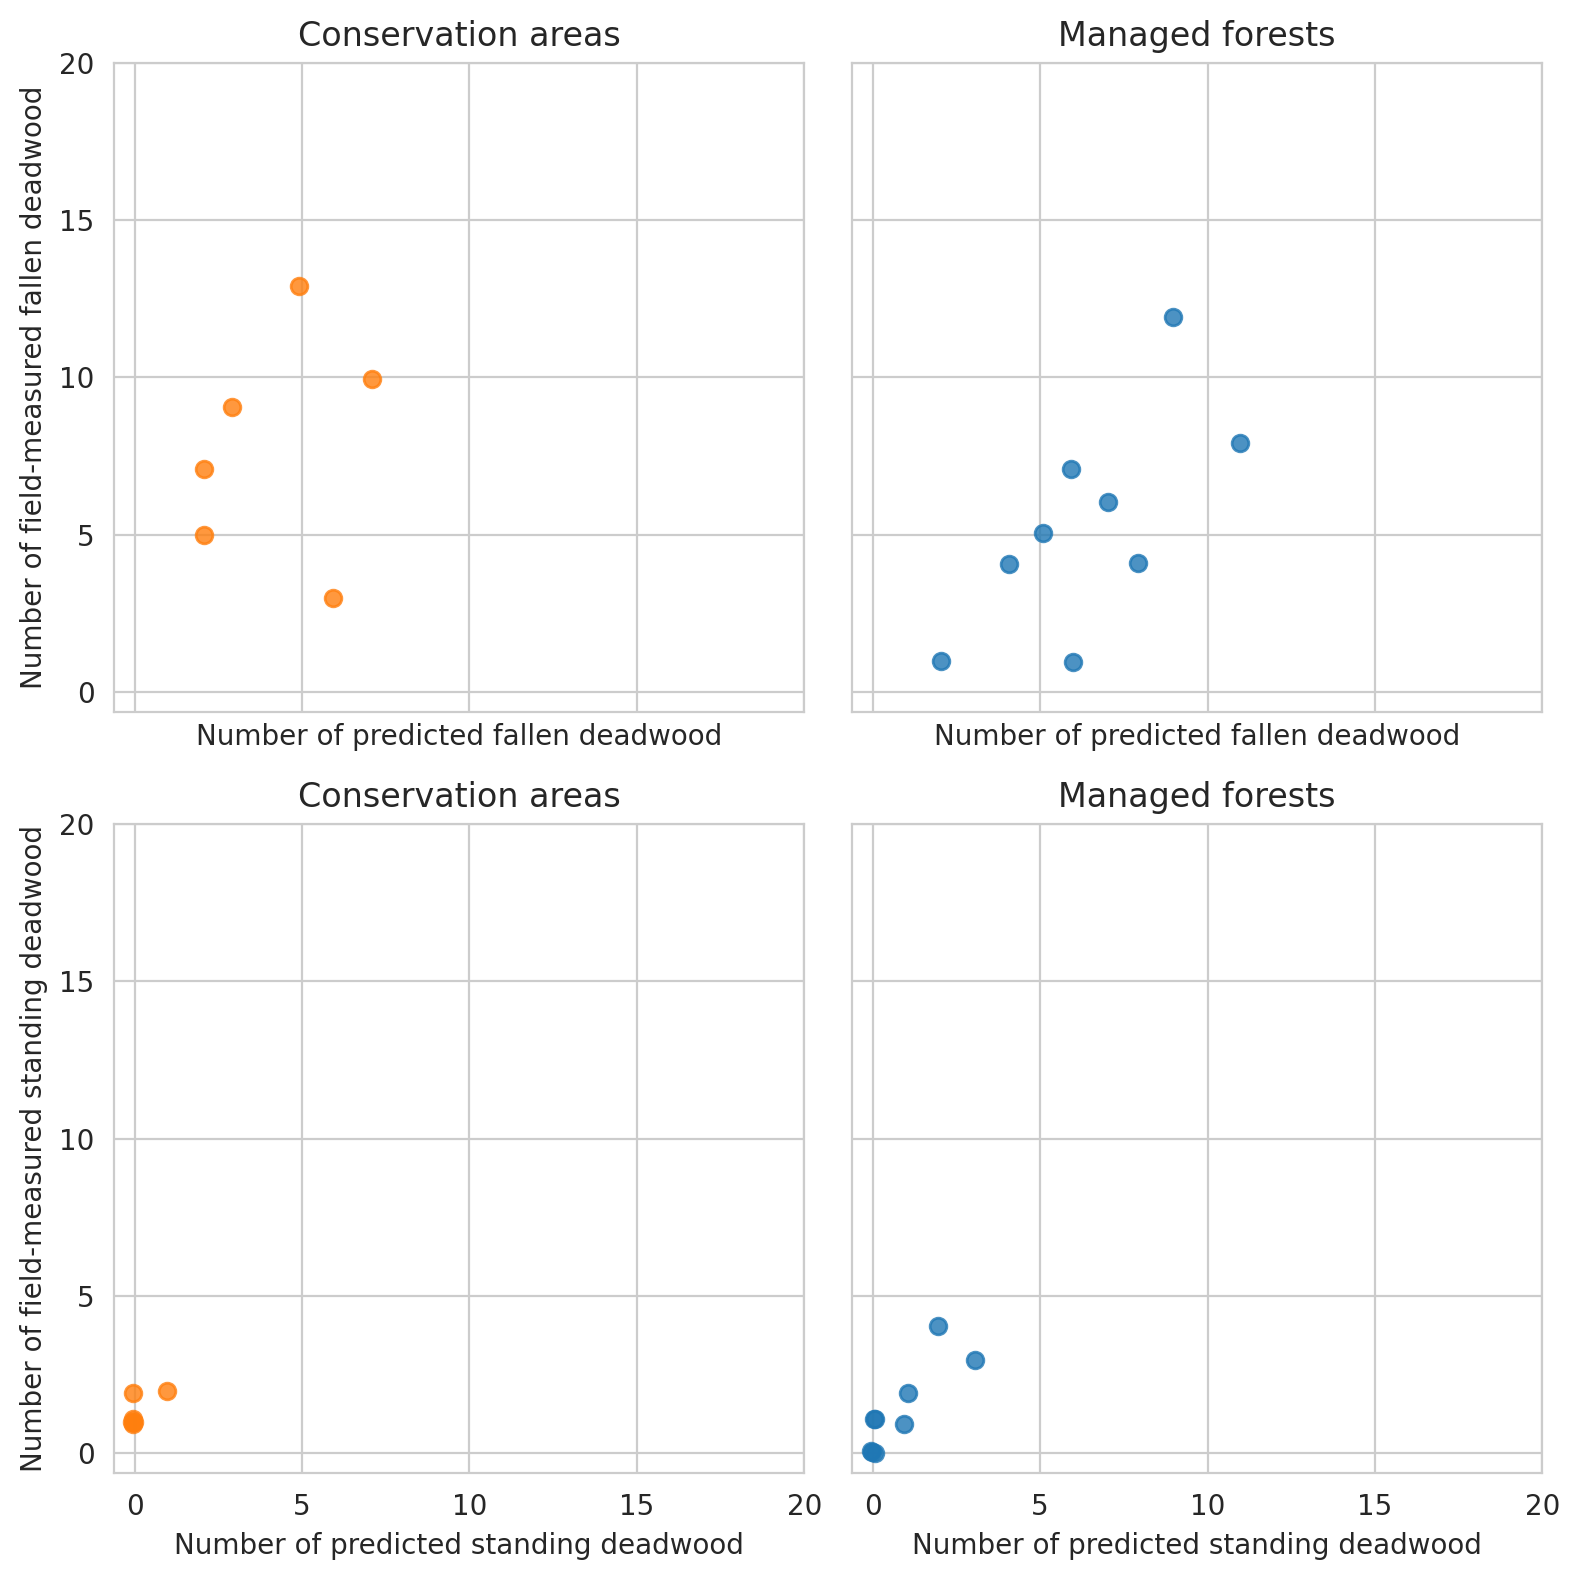

In [35]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()

Next the relationship between canopy cover and types of detected deadwood.

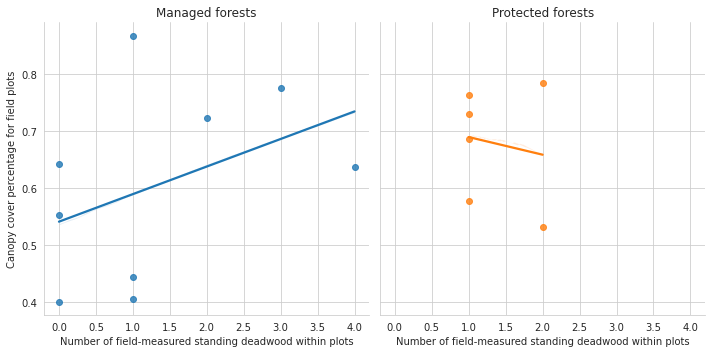

In [36]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured standing deadwood within plots')
plt.show()

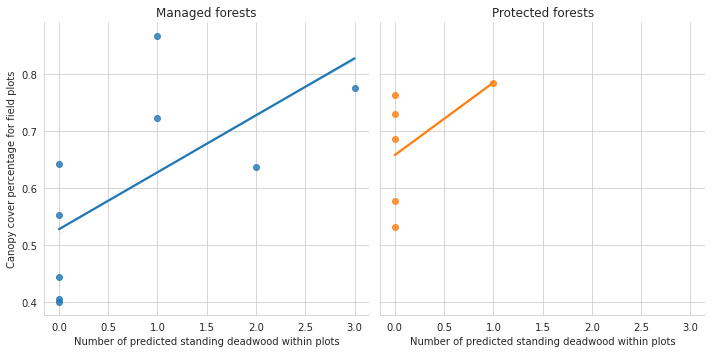

In [37]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_pred', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted standing deadwood within plots')
plt.show()

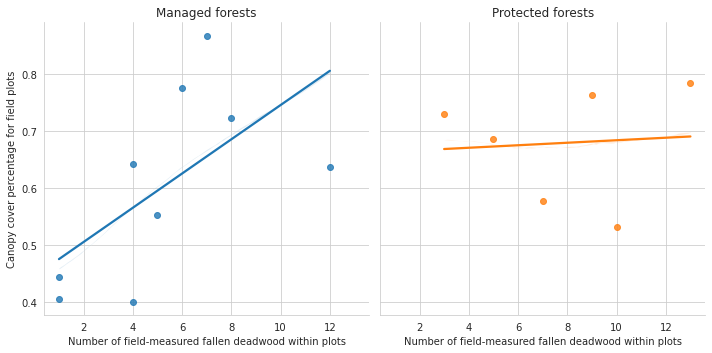

In [38]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured fallen deadwood within plots')
plt.show()

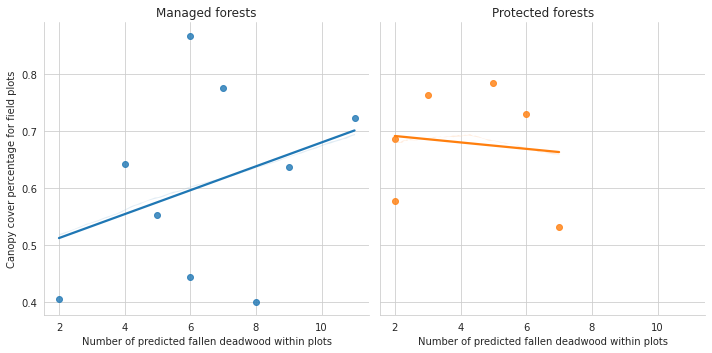

In [39]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_pred', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted fallen deadwood within plots')
plt.show()

Note that for the test set there are too few plots to draw meaningful conclusions.

Read individual tree measurements, and convert `l` from decimeters to meters.

In [40]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

Add information about conservation area to tree data.

In [41]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

In [42]:
preds_in_plots['conservation'] = preds_in_plots.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

In [43]:
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)
preds_in_plots['tree_length'] = preds_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account. Lengths are binned into 1m bins.

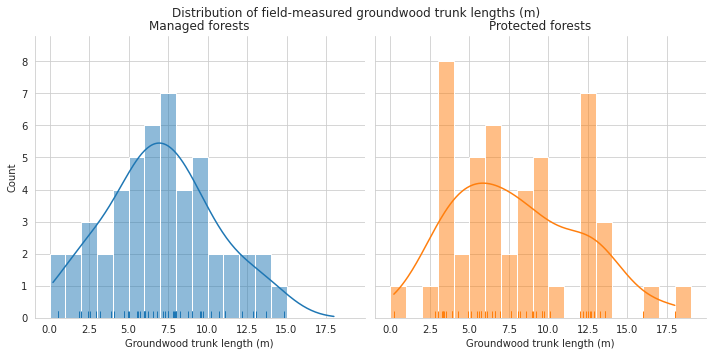

In [44]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', 
                hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=1, binrange=(0, max(tree_data[tree_data.tree_class == 4].l))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

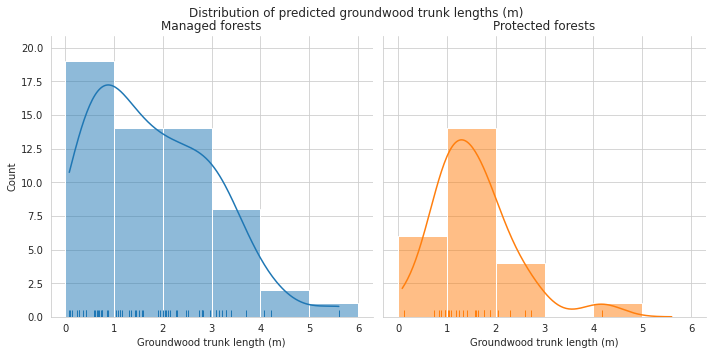

In [45]:
g = sns.displot(data=preds_in_plots[preds_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot. DBHs are binned into 50mm bins.

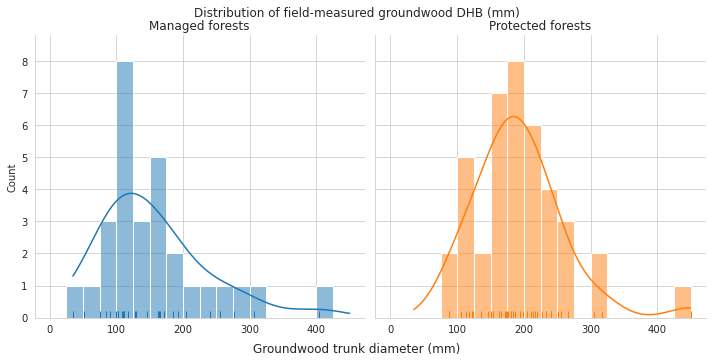

In [46]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)], x='dbh', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False, binwidth=25,
                binrange=(0, max(tree_data[(tree_data.tree_class == 4)].dbh))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

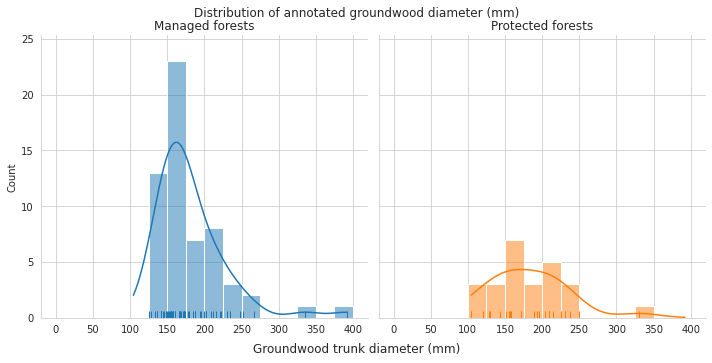

In [47]:
preds_in_plots['diam'] = preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=preds_in_plots[(preds_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds_in_plots[(preds_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [48]:
pd.pivot_table(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)],
               index=['conservation'], values=['l', 'dbh'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean           min            max         
                     dbh         l dbh         l  dbh        l
conservation                                                  
0             155.275862  8.124393  35  1.866795  404  13.7169
1             192.725000  7.360910  87  2.792713  450  16.0000
All           176.985507  7.681794  35  1.866795  450  16.0000

In [49]:
pd.pivot_table(data=preds_in_plots[preds_in_plots.label==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             181.563623    1.780934  125.149180    0.083259  392.214472   
1             181.602973    1.550612  104.450694    0.116236  330.616991   
All           181.575476    1.711560  104.450694    0.083259  392.214472   

                          
             tree_length  
conservation              
0               5.605484  
1               4.169457  
All             5.605484

In [50]:
preds_in_plots['v_ddw'] = preds_in_plots.geometry.apply(cut_cone_volume)
plot_dw_data['v_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[(preds_in_plots.plot_id == row.id) &
                                                                        (preds_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)

In [51]:
plot_dw_data['v_dw_plot'] = (plot_dw_data['v_dw']/10000)*np.pi*9**2
plot_dw_data['v_ddw_plot'] = (plot_dw_data['v_ddw']/10000)*np.pi*9**2
plot_dw_data['v_udw_plot'] = plot_dw_data.v_dw_plot - plot_dw_data.v_ddw_plot

In [52]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,1.476682,88.948335,29.528714,22.513292,28.686318,9
1,65.155283,139.171786,82.494768,71.816212,28.298432,6
All,1.476682,139.171786,50.715136,48.100161,38.439837,15


In [53]:
plot_dw_data['v_ddw_pred_ha'] = (10000 * plot_dw_data.v_ddw_pred) / (np.pi * 9**2)

pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,7.838919,65.897521,26.104188,17.225721,21.262738,9
1,3.765071,25.724468,11.687232,8.610156,8.194514,6
All,3.765071,65.897521,20.337406,13.273016,18.324140,15


# Sudenpesänkangas

Read data and do some wrangling.

In [54]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_preds = gpd.read_file('../results/sudenpesankangas/spk_merged_new.geojson')
evo_plot_circles = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_plot_circles['id'] = evo_plot_circles['id'].astype(int)
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

cons_evo = conservation_areas[conservation_areas.geometry.intersects(box(*evo_anns.total_bounds))]
cons_evo = gpd.clip(cons_evo, evo_grid)

In [55]:
def match_plotid_spk(geom, plots):
    for r in plots.itertuples():
        if r.geometry.intersects(geom):
            return r.id
    return None

def match_vplot_spk(geom, plots):
    for p in plots.itertuples():
        if geom.intersects(p.geometry):
            return f'{p.fid}_{int(p.id)}'

Get up-to-date field data

In [56]:
evo_plots_updated = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018.txt', sep=' ')
evo_plots_luke = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018_LUKE.txt', sep=' ')
evo_plots_updated = gpd.GeoDataFrame(evo_plots_updated, geometry=gpd.points_from_xy(evo_plots_updated.x,
                                                                                    evo_plots_updated.y),
                                     crs='epsg:3067')
evo_plots_luke = gpd.GeoDataFrame(evo_plots_luke, geometry=gpd.points_from_xy(evo_plots_luke.x,
                                                                              evo_plots_luke.y),
                                     crs='epsg:3067')
evo_plots = pd.concat([evo_plots_updated, evo_plots_luke])
evo_plots.rename(columns= {c: c.replace('.','_') for c in evo_plots.columns}, inplace=True)

In [57]:
evo_plots['spk_id'] = evo_plots.geometry.apply(lambda row: match_plotid_spk(row, evo_plot_circles))

In [58]:
evo_plots.dropna(subset='spk_id', inplace=True)

In [59]:
evo_plots['geometry'] = evo_plots.spk_id.apply(lambda row: evo_plot_circles[evo_plot_circles.id == row].geometry.iloc[0])

In [60]:
evo_plots.drop(columns=['id'], inplace=True)
evo_plots.rename(columns={'spk_id': 'id'}, inplace=True)

In [61]:
evo_plots['conservation'] = evo_plots.geometry.apply(lambda row: 1 if cons_evo.geometry.unary_union.intersects(row)
                                                     else 0)

In [62]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

In [63]:
evo_plots = evo_plots[evo_plots.id.isin(evo_anns.plot_id.unique())]

In [64]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns_in_plots = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

In [65]:
evo_preds['conservation'] = evo_preds.geometry.apply(lambda row: 1 if any(cons_evo.geometry.contains(row))
                                                         else 0)

In [66]:
evo_preds['vplot_id'] = evo_preds.geometry.apply(lambda row: match_vplot_spk(row, evo_grid))
evo_preds['plot_id'] = evo_preds.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_preds_in_plots = evo_preds[evo_preds.geometry.intersects(evo_plots.geometry.unary_union)].copy()
evo_preds_in_plots['plot_id'] = evo_preds_in_plots.plot_id.astype(int)

## Predictions vs annotations, all available data

In [67]:
pd.crosstab(evo_anns.conservation, evo_anns.label, margins=True)

label,groundwood,uprightwood,All
conservation,,,
0,2369,386,2755
1,1546,1033,2579
All,3915,1419,5334


In [68]:
pd.crosstab(evo_preds.conservation, evo_preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,2281,379,2660
1,1642,780,2422
All,3923,1159,5082


In [69]:
evo_anns['tree_length'] = evo_anns.geometry.apply(get_len)
evo_preds['tree_length'] = evo_preds.geometry.apply(get_len)
evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
evo_preds['diam'] = evo_preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

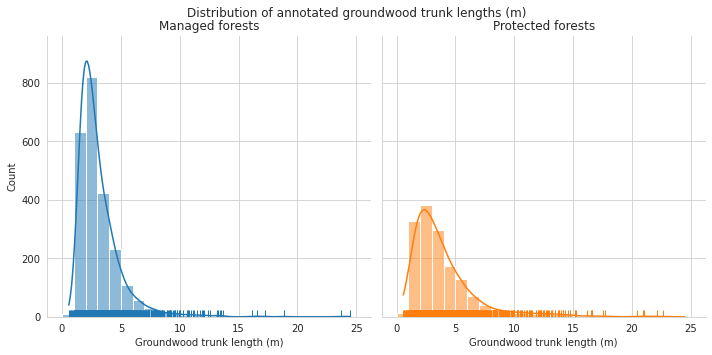

In [70]:
g = sns.displot(data=evo_anns[evo_anns.label=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

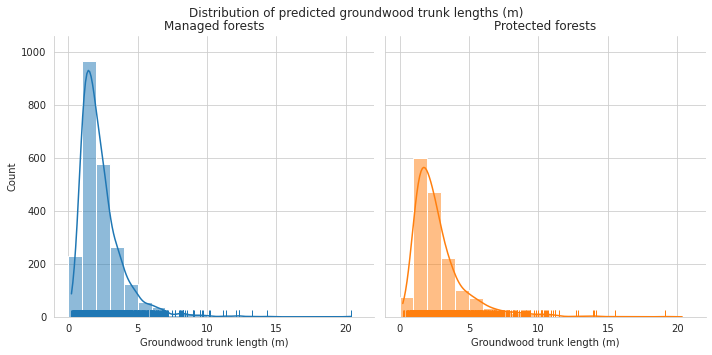

In [71]:
g = sns.displot(data=evo_preds[evo_preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

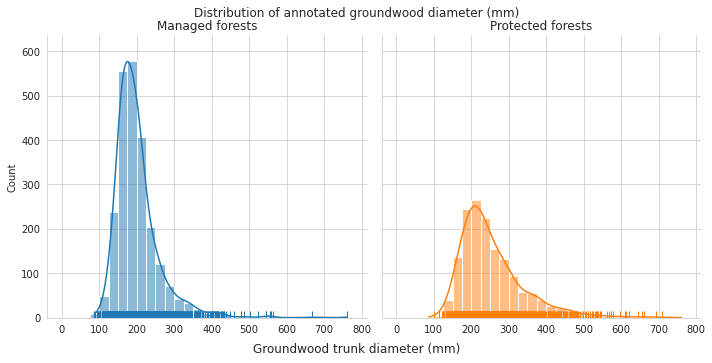

In [72]:
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_anns[(evo_anns.label=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

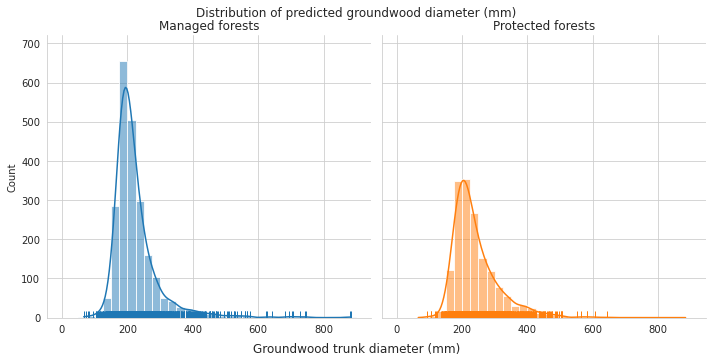

In [73]:
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_preds[(evo_preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [74]:
evo_anns[evo_anns.label=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                       margins=True, aggfunc=['mean', 'min', 'max'])

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             200.474161    3.113435   85.977992    0.605847  760.781151   
1             254.250328    3.914179  101.096059    0.575351  709.170305   
All           221.709909    3.429642   85.977992    0.575351  760.781151   

                          
             tree_length  
conservation              
0              24.479043  
1              22.625422  
All            24.479043

In [75]:
evo_preds[evo_preds.layer=='groundwood'].pivot_table(index='conservation', values=['diam', 'tree_length'], 
                                           margins=True, aggfunc=['mean', 'min', 'max'])

mean                    min                     max  \
                    diam tree_length       diam tree_length        diam   
conservation                                                              
0             223.399732    2.342271  66.289677    0.228875  883.721069   
1             240.588041    2.803711  92.351583    0.251623  642.847350   
All           230.594023    2.535410  66.289677    0.228875  883.721069   

                          
             tree_length  
conservation              
0              20.358955  
1              19.092797  
All            20.358955

In [76]:
evo_anns['area_m2'] = evo_anns.geometry.area
evo_preds['area_m2'] = evo_preds.geometry.area

In [77]:
evo_anns[evo_anns.label=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                                    aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,3.142462,1212.990283
1,5.811285,6003.057735
All,5.085305,7216.048018


In [78]:
evo_preds[evo_preds.layer=='uprightwood'].pivot_table(index='conservation', values=['area_m2'], margins=True,
                                                      aggfunc=['mean', 'sum'])

,mean,sum
,area_m2,area_m2
conservation,,
0,4.131254,1565.745270
1,6.170653,4813.109216
All,5.503757,6378.854485


In [79]:
evo_anns['v_ddw'] = evo_anns.geometry.apply(cut_cone_volume)
evo_preds['v_ddw'] = evo_preds.geometry.apply(cut_cone_volume)

In [80]:
evo_vplot_area = evo_grid.area.sum()
evo_cons_area = cons_evo.area.sum()
evo_man_area = evo_vplot_area - evo_cons_area
evo_man_ha = evo_man_area / 10000
evo_cons_ha = evo_cons_area / 10000

In [81]:
evo_ann_est_v_man = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==0)].v_ddw.sum()/evo_man_ha
evo_ann_est_v_cons = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_ann_est_v = evo_anns[(evo_anns.label=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [82]:
evo_pred_est_v_man = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==0)].v_ddw.sum()/evo_man_ha
evo_pred_est_v_cons = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_pred_est_v = evo_preds[(evo_preds.layer=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [83]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {evo_ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {evo_ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {evo_ann_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 7.08 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 13.97 ha/m³
Estimated groundwood volume in both types, based on annotations: 9.90 ha/m³


In [84]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {evo_pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {evo_pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {evo_pred_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 7.60 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 10.19 ha/m³
Estimated groundwood volume in both types, based on predictions: 8.66 ha/m³


## Predictions vs field data, plot-wise

Add canopy density based on LiDAR derived canopy height model. The density is the percentage of field plot area with height above 2 meters.

In [85]:
pcts = []

with rio.open('../../data/raw/sudenpesankangas/full_mosaics/sudenpesankangas_chm.tif') as src:
    for row in evo_plots.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [86]:
evo_plots['canopy_cover_pct'] = pcts

In [87]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.237288,0.989960,0.782452,0.200439,42
1,0.678000,0.991992,0.869878,0.085901,29
All,0.237288,0.991992,0.818162,0.168393,71


Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [88]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label!='groundwood'].plot_id.unique() else 0, axis=1)

evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_ddw_plot'] = np.round((evo_plots['n_ddw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_udw_plot'] = evo_plots.n_dw_plot - evo_plots.n_ddw_plot
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(cons_evo.geometry.contains(row.geometry))
                                                        else 0, axis=1)

In [89]:
evo_plots['n_dw_pred'] = evo_plots.apply(lambda row: evo_preds.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer!='groundwood'].plot_id.unique() else 0, axis=1)



In [90]:
evo_plots.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann', 
                                                    'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,65,14,55,14,68,14
1,22,29,32,29,92,27
All,87,43,87,43,160,41


Plot the relationship between annotated and field data.

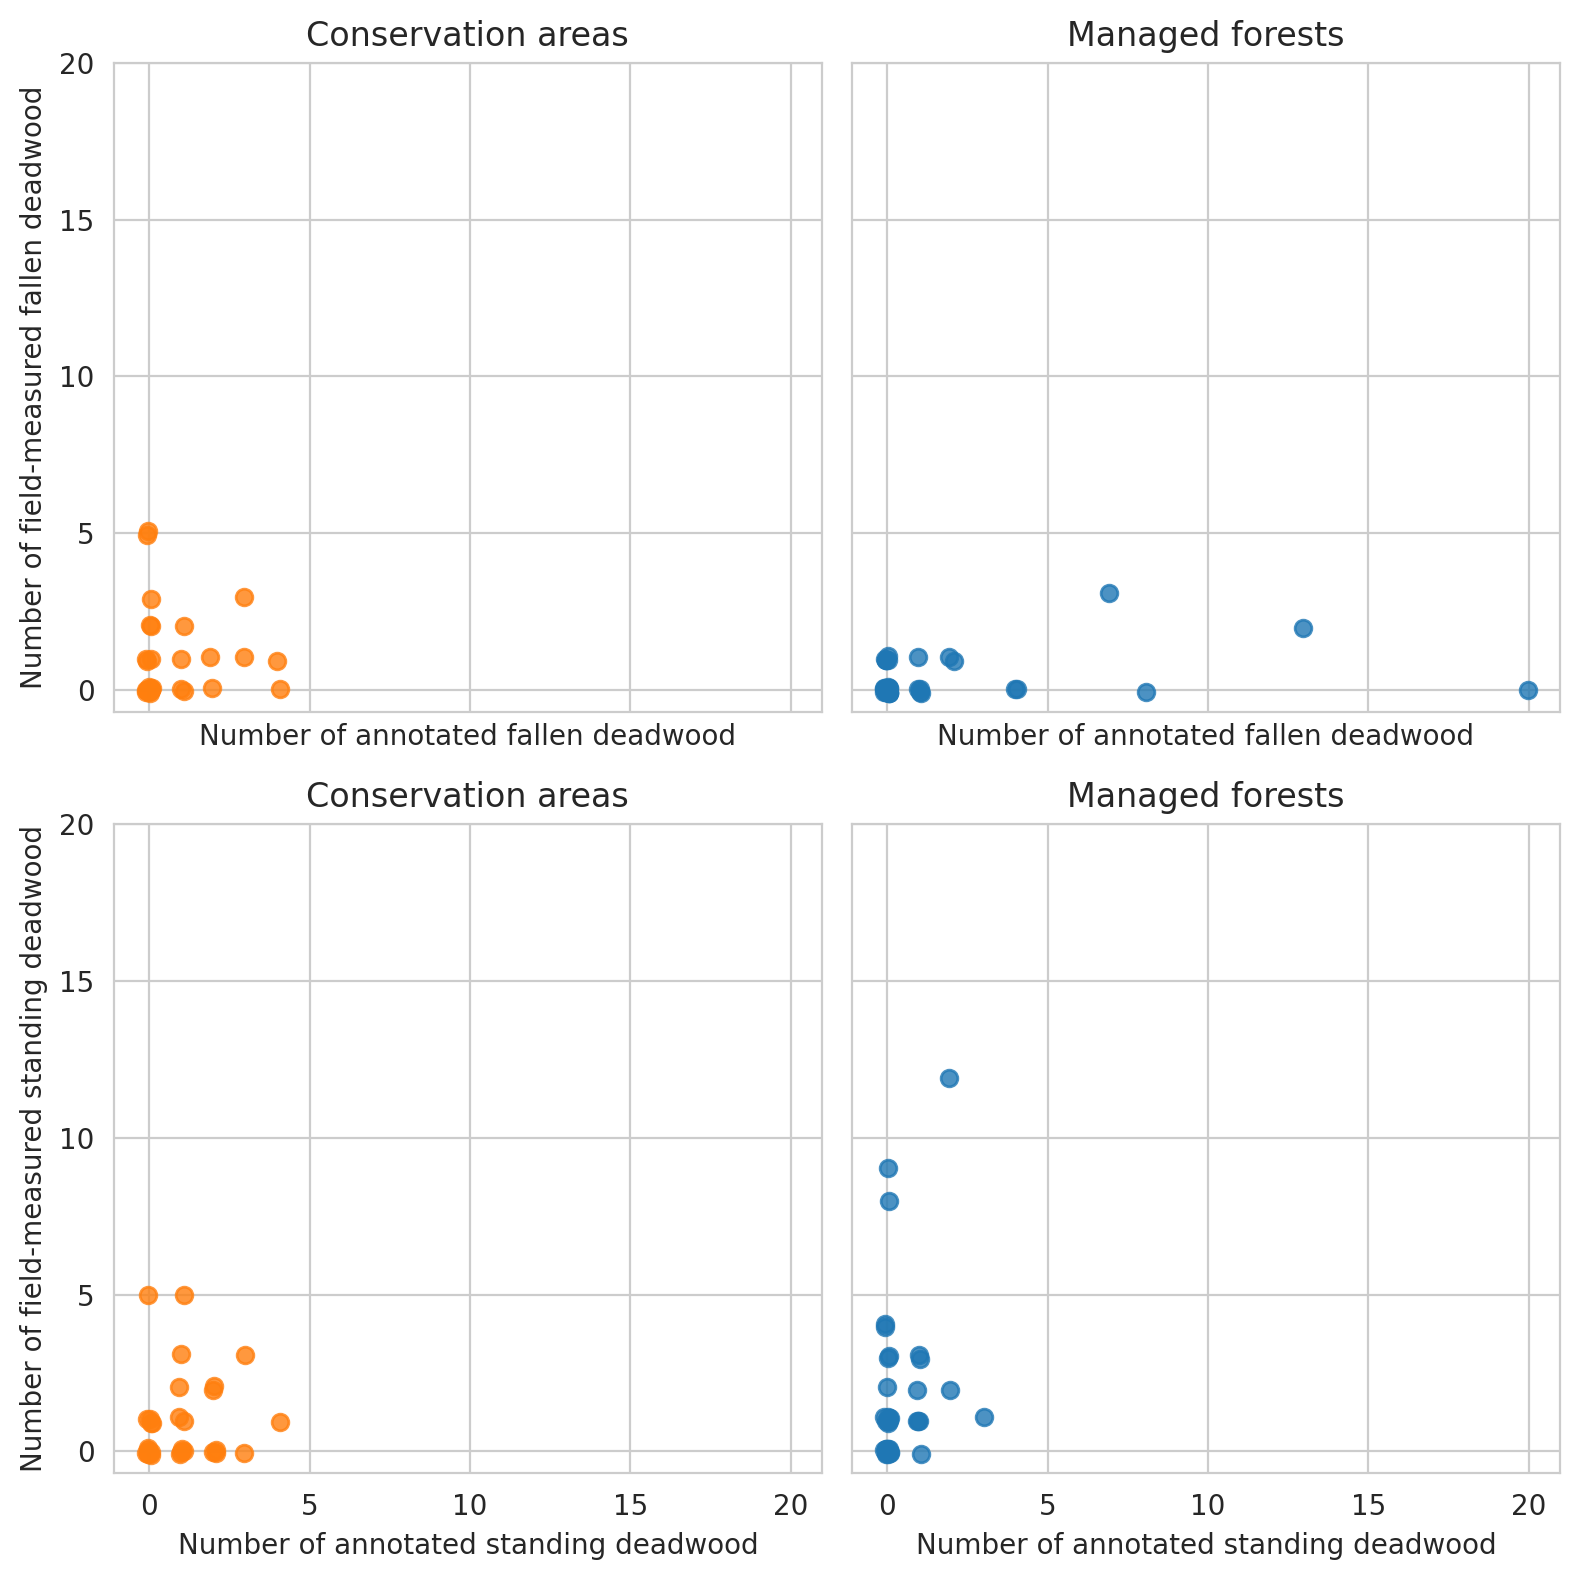

In [91]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()

Same for field data and predictions.

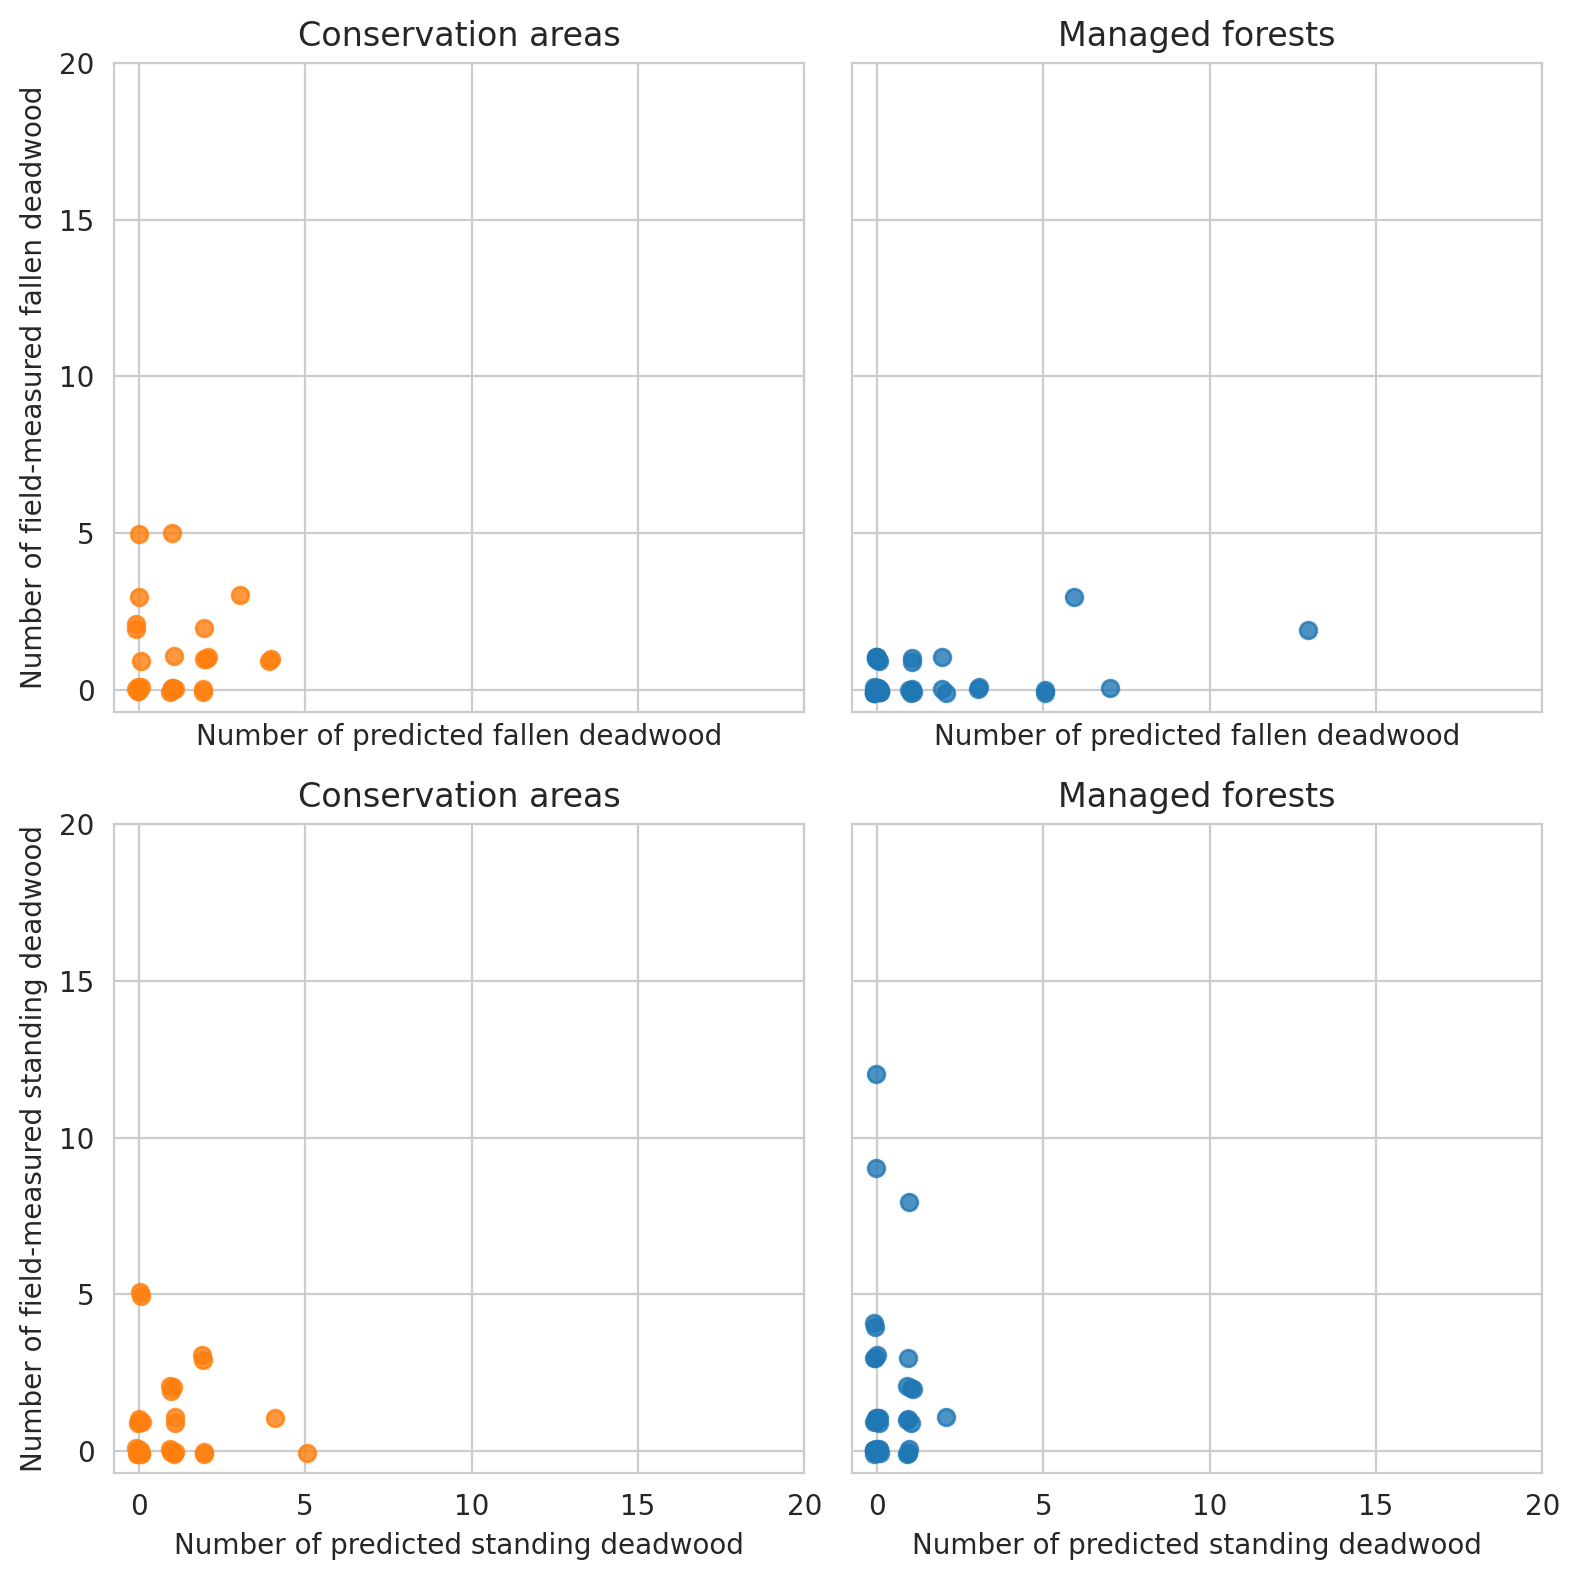

In [92]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()

Relationship between canopy cover and deadwood.

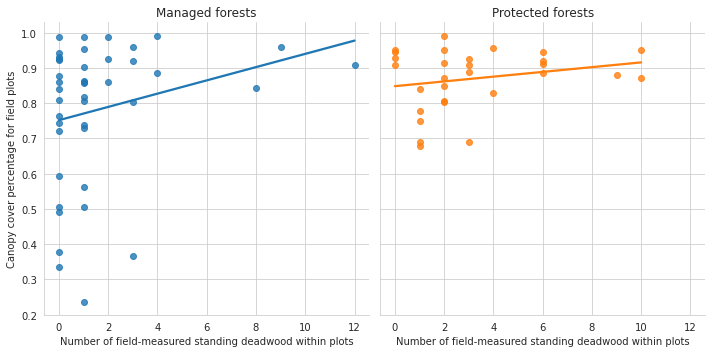

In [103]:
g = sns.lmplot(data=evo_plots, x='n_udw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured standing deadwood within plots')
plt.show()

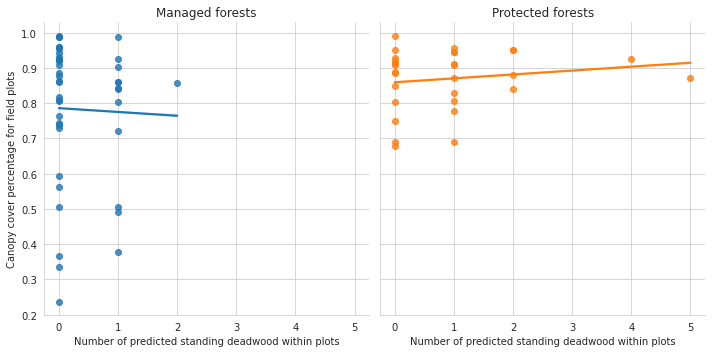

In [104]:
g = sns.lmplot(data=evo_plots, x='n_udw_pred', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted standing deadwood within plots')
plt.show()

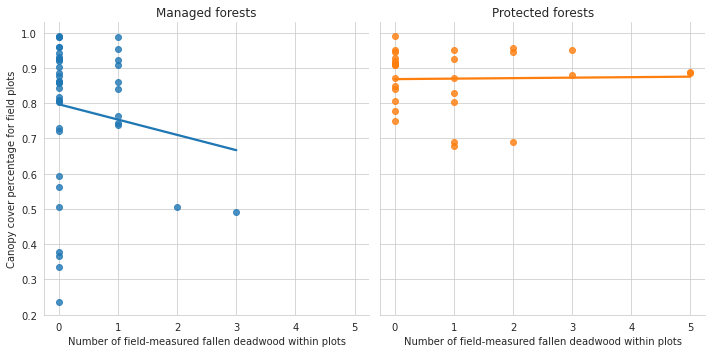

In [105]:
g = sns.lmplot(data=evo_plots, x='n_ddw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured fallen deadwood within plots')
plt.show()

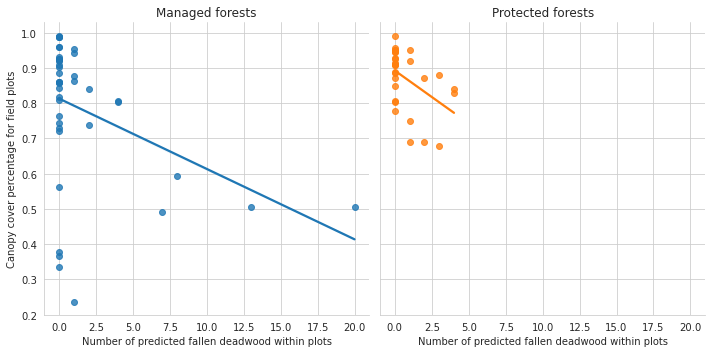

In [106]:
g = sns.lmplot(data=evo_plots, x='n_ddw_ann', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of predicted fallen deadwood within plots')
plt.show()

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has around 50 downed deadwood with dbh measured.

In [93]:
evo_field_data = evo_field_data[evo_field_data.plotid.isin(evo_plots.id.unique())]

In [94]:
evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

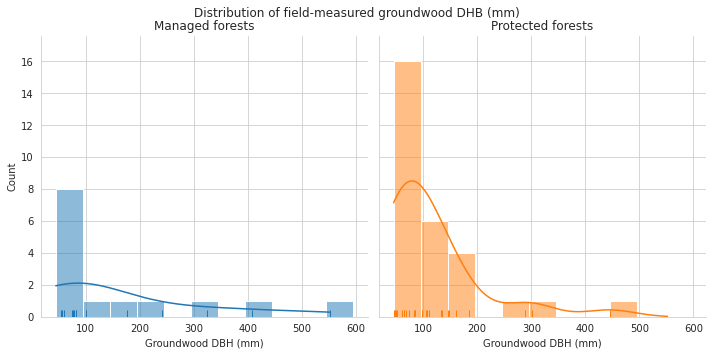

In [95]:
g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=50) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

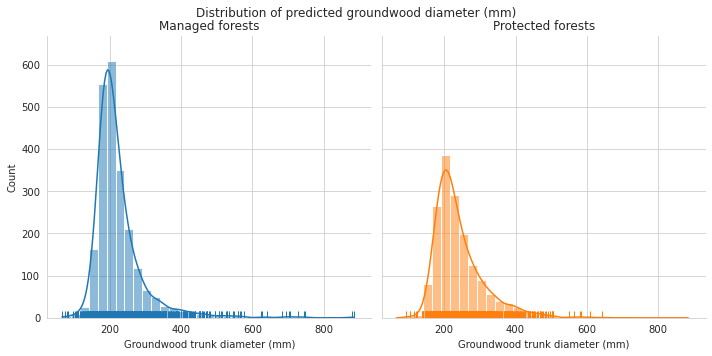

In [96]:
evo_preds_in_plots['diam'] = evo_preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

In [97]:
evo_preds_in_plots['v_ddw'] = evo_preds_in_plots.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_pred'] = evo_plots.apply(lambda row: evo_preds_in_plots[(evo_preds_in_plots.plot_id == row.id) &
                                                              (evo_preds_in_plots.layer == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

In [98]:
evo_plots['v_ddw_pred_ha'] = (10000 * evo_plots.v_ddw_pred) / (np.pi * 9**2)

In [99]:
pd.pivot_table(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)],
               index=['conservation'], values=['est_pituus_m', 'lapimitta_mm'],
               aggfunc=['mean', 'min', 'max', 'count'], margins=True)

mean                       min                       max  \
             est_pituus_m lapimitta_mm est_pituus_m lapimitta_mm est_pituus_m   
conservation                                                                    
0               13.609571   169.357143        5.934           55       34.211   
1               11.905690   115.896552        5.446           45       28.101   
All             12.460442   133.302326        5.446           45       34.211   

                                 count               
             lapimitta_mm est_pituus_m lapimitta_mm  
conservation                                         
0                     552           14           14  
1                     445           29           29  
All                   552           43           43

In [100]:
evo_preds_in_plots['tree_length'] = evo_preds_in_plots.geometry.apply(get_len)

pd.pivot_table(data=evo_preds_in_plots[evo_preds_in_plots.label==2], index=['conservation'], 
               values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             242.822326    2.516567  149.543873    0.914834  527.381234   
1             225.455753    2.376353  158.182570    1.016799  372.173396   
All           236.434621    2.464994  149.543873    0.914834  527.381234   

                          
             tree_length  
conservation              
0               9.035185  
1               6.430616  
All             9.035185

In [101]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,123.004587,5.522673,0.0,23.497052,42
1,0.0,98.258093,6.338610,0.0,18.873961,29
All,0.0,123.004587,5.855943,0.0,21.587804,71


In [102]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,0.0,123.593990,8.646433,0.000000,21.642447,42
1,0.0,28.585354,5.410912,3.072084,7.541503,29
All,0.0,123.593990,7.324882,0.000000,17.310725,71
